Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [3]:
df.dtypes

Passengers    int64
dtype: object

**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [4]:
passengers = np.array(df['Passengers'], dtype=np.float32)

In [5]:
passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [6]:
train_size = int(len(passengers) * 0.67)

train_data = passengers[:train_size]
validation_data = passengers[train_size:]

train_data, validation_data

(array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
        114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
        209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
        272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
        302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
        315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
        318., 374., 413., 405., 355., 306., 271., 306.], dtype=float32),
 array([315., 301., 356., 348., 355., 422., 465., 467., 404., 347., 305.,
        336., 340., 318., 362., 348., 363., 435., 491., 505., 404., 359.,
        310., 337., 360., 342., 406., 396., 420., 472., 548., 559., 463.,
        407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606.,
        508., 461., 390., 432.], dtype=

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [7]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        X.append(window)
        y.append(dataset[i + lookback])
    
    X = torch.tensor(X).float().unsqueeze(-1)
    y = torch.tensor(y).float().unsqueeze(-1)
    
    return X, y

In [8]:
lookback = 1
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(validation_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


C:\Users\lyuda\AppData\Local\Temp\ipykernel_35772\2538749688.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.tensor(X).float().unsqueeze(-1)


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [9]:
class AirModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(AirModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM шар
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Лінійний шар для регресії
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

# Створюємо модель з параметрами
input_dim = 1
hidden_dim = 50
layer_dim = 1
output_dim = 1

model = AirModel(input_dim, hidden_dim, layer_dim, output_dim)

# Тестуємо модель на вхідному тензорі
input_tensor = torch.tensor([[112.]]).float().unsqueeze(0)
output = model(input_tensor)

print(output)

tensor([[-0.2974]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [10]:
# Визначаємо dataset
train_dataset = TensorDataset(X_train, y_train)


# Визначаємо data loader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
next(iter(train_loader))

[tensor([[[118.]],
 
         [[204.]],
 
         [[284.]],
 
         [[133.]],
 
         [[118.]],
 
         [[172.]],
 
         [[171.]],
 
         [[188.]]]),
 tensor([[132.],
         [188.],
         [277.],
         [114.],
         [115.],
         [194.],
         [180.],
         [235.]])]

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [11]:
# Визначаємо функцію для обчислення RMSE
def compute_rmse(preds, targets):
    return torch.sqrt(torch.mean((preds - targets) ** 2))

# Ініціалізація Adam-оптимізатора та функції втрат MSE
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, train_loader, optimizer, criterion):
    model.train()  # Включаємо режим тренування
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Прямий прохід
        optimizer.zero_grad()
        output = model(X_batch)
        
        # Обчислюємо втрату
        loss = criterion(output, y_batch)
        
        # Зворотний прохід
        loss.backward()
        
        # Оновлюємо ваги
        optimizer.step()
        
        # Додаємо втрату для обчислення середньої похибки
        train_loss += loss.item()
    
    # Середня втрата на кожній епосі
    avg_train_loss = train_loss / len(train_loader)
    
    return avg_train_loss


# Основний цикл тренування
n_epochs = 2000
losses = []

for epoch in range(n_epochs):
    avg_train_loss = train(model, train_loader, optimizer, criterion)  # Викликаємо функцію тренування
    losses.append(avg_train_loss)

    # Валідація моделі кожні 100 епох
    if epoch % 100 == 0:
        model.eval()  # Включаємо режим оцінки

        with torch.no_grad():  # Вимикаємо обчислення градієнтів
            # Прогноз на тренувальних даних
            train_preds = model(X_train).squeeze(-1)
            train_rmse = compute_rmse(train_preds, y_train)
            
            # Прогноз на тестових даних
            test_preds = model(X_test).squeeze(-1)
            test_rmse = compute_rmse(test_preds, y_test)
        
        print(f"Epoch {epoch}: train RMSE {train_rmse.item():.4f}, test RMSE {test_rmse.item():.4f}")

Epoch 0: train RMSE 226.3168, test RMSE 422.7295
Epoch 100: train RMSE 186.5435, test RMSE 381.1243
Epoch 200: train RMSE 154.6402, test RMSE 346.7843
Epoch 300: train RMSE 126.7136, test RMSE 315.2329
Epoch 400: train RMSE 103.3960, test RMSE 286.4034
Epoch 500: train RMSE 88.6383, test RMSE 260.5383
Epoch 600: train RMSE 83.1780, test RMSE 235.7191
Epoch 700: train RMSE 82.5798, test RMSE 212.7262
Epoch 800: train RMSE 84.4772, test RMSE 192.0923
Epoch 900: train RMSE 86.6161, test RMSE 173.7055
Epoch 1000: train RMSE 89.8711, test RMSE 158.0636
Epoch 1100: train RMSE 91.8529, test RMSE 145.1505
Epoch 1200: train RMSE 92.3324, test RMSE 134.9255
Epoch 1300: train RMSE 93.4276, test RMSE 126.2347
Epoch 1400: train RMSE 95.4274, test RMSE 120.7092
Epoch 1500: train RMSE 93.9141, test RMSE 118.4290
Epoch 1600: train RMSE 95.3309, test RMSE 113.3554
Epoch 1700: train RMSE 94.5022, test RMSE 111.8589
Epoch 1800: train RMSE 97.4421, test RMSE 106.1163
Epoch 1900: train RMSE 96.4211, test R

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

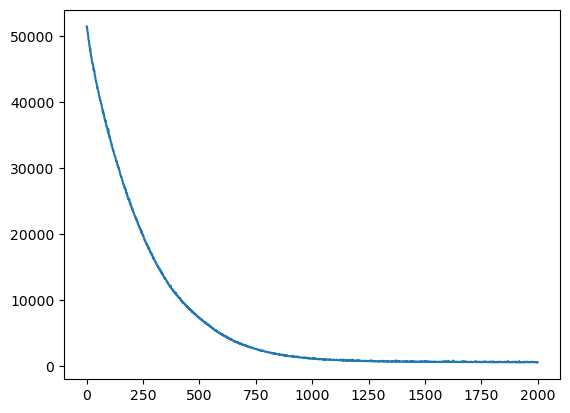

In [12]:
plt.plot(losses);

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

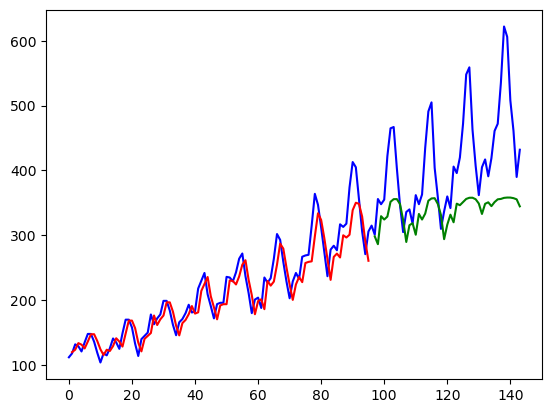

In [13]:
def plot_predicts():
    with torch.no_grad():
        # Зсув прогнозів для тренувальних даних
        train_plot = np.ones_like(passengers) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_plot[lookback:train_size] = model(X_train)[:, -1]

        # Зсув прогнозів для тестових даних
        test_plot = np.ones_like(passengers) * np.nan
        test_plot[train_size+lookback:len(passengers)] = model(X_test)[:, -1]

    # Візуалізація результатів
    plt.plot(passengers, c='b')  # Реальні дані
    plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
    plt.plot(test_plot, c='g')   # Прогнози на тестових даних
    plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [9]:
class AirModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(AirModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM шар
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Лінійний шар для регресії
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

# Створюємо 2 модель з параметрами
input_dim = 1
hidden_dim = 100
layer_dim = 1
output_dim = 1

model = AirModel(input_dim, hidden_dim, layer_dim, output_dim)

# Тестуємо модель на вхідному тензорі
input_tensor = torch.tensor([[112.]]).float().unsqueeze(0)
output = model(input_tensor)

print(output)

tensor([[-0.0375]], grad_fn=<AddmmBackward0>)


In [10]:
# Визначаємо dataset
train_dataset = TensorDataset(X_train, y_train)


# Визначаємо data loader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
next(iter(train_loader))

[tensor([[[306.]],
 
         [[121.]],
 
         [[194.]],
 
         [[227.]],
 
         [[150.]],
 
         [[243.]],
 
         [[145.]],
 
         [[270.]]]),
 tensor([[271.],
         [135.],
         [196.],
         [234.],
         [178.],
         [264.],
         [150.],
         [315.]])]

In [11]:
# Визначаємо функцію для обчислення RMSE
def compute_rmse(preds, targets):
    return torch.sqrt(torch.mean((preds - targets) ** 2))

# Ініціалізація Adam-оптимізатора та функції втрат MSE
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, train_loader, optimizer, criterion):
    model.train()  # Включаємо режим тренування
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Прямий прохід
        optimizer.zero_grad()
        output = model(X_batch)
        
        # Обчислюємо втрату
        loss = criterion(output, y_batch)
        
        # Зворотний прохід
        loss.backward()
        
        # Оновлюємо ваги
        optimizer.step()
        
        # Додаємо втрату для обчислення середньої похибки
        train_loss += loss.item()
    
    # Середня втрата на кожній епосі
    avg_train_loss = train_loss / len(train_loader)
    
    return avg_train_loss


# Основний цикл тренування
n_epochs = 2000
losses = []

for epoch in range(n_epochs):
    avg_train_loss = train(model, train_loader, optimizer, criterion)  # Викликаємо функцію тренування
    losses.append(avg_train_loss)

    # Валідація моделі кожні 100 епох
    if epoch % 100 == 0:
        model.eval()  # Включаємо режим оцінки

        with torch.no_grad():  # Вимикаємо обчислення градієнтів
            # Прогноз на тренувальних даних
            train_preds = model(X_train).squeeze(-1)
            train_rmse = compute_rmse(train_preds, y_train)
            
            # Прогноз на тестових даних
            test_preds = model(X_test).squeeze(-1)
            test_rmse = compute_rmse(test_preds, y_test)
        
        print(f"Epoch {epoch}: train RMSE {train_rmse.item():.4f}, test RMSE {test_rmse.item():.4f}")

Epoch 0: train RMSE 225.8431, test RMSE 422.2556
Epoch 100: train RMSE 146.4565, test RMSE 337.7303
Epoch 200: train RMSE 97.7641, test RMSE 278.7258
Epoch 300: train RMSE 80.3824, test RMSE 234.6983
Epoch 400: train RMSE 83.2578, test RMSE 197.9749
Epoch 500: train RMSE 86.5157, test RMSE 168.9719
Epoch 600: train RMSE 90.9904, test RMSE 147.0122
Epoch 700: train RMSE 95.1253, test RMSE 132.1008
Epoch 800: train RMSE 94.4360, test RMSE 119.8610
Epoch 900: train RMSE 94.3001, test RMSE 115.8186
Epoch 1000: train RMSE 95.4482, test RMSE 106.3745
Epoch 1100: train RMSE 96.0611, test RMSE 106.9373
Epoch 1200: train RMSE 96.3354, test RMSE 103.3832
Epoch 1300: train RMSE 99.8596, test RMSE 97.5799
Epoch 1400: train RMSE 99.1344, test RMSE 99.1656
Epoch 1500: train RMSE 96.8310, test RMSE 101.0362
Epoch 1600: train RMSE 99.3565, test RMSE 96.2347
Epoch 1700: train RMSE 97.2466, test RMSE 102.3165
Epoch 1800: train RMSE 98.5641, test RMSE 97.2291
Epoch 1900: train RMSE 96.1486, test RMSE 99.

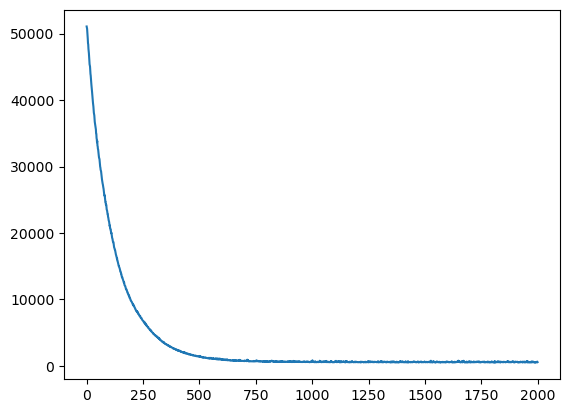

In [12]:
plt.plot(losses);

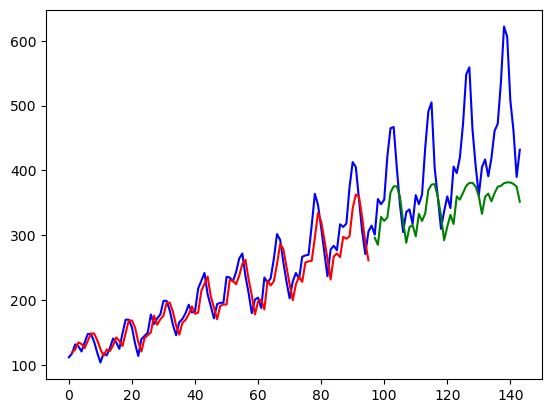

In [13]:
def plot_predicts():
    with torch.no_grad():
        # Зсув прогнозів для тренувальних даних
        train_plot = np.ones_like(passengers) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_plot[lookback:train_size] = model(X_train)[:, -1]

        # Зсув прогнозів для тестових даних
        test_plot = np.ones_like(passengers) * np.nan
        test_plot[train_size+lookback:len(passengers)] = model(X_test)[:, -1]

    # Візуалізація результатів
    plt.plot(passengers, c='b')  # Реальні дані
    plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
    plt.plot(test_plot, c='g')   # Прогнози на тестових даних
    plt.show()

plot_predicts()

Тут вже трохи кращі предікти модельки, але всеодно ми не навчились враховувати тренд на зростання